In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import importlib
import funs
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from kneed import KneeLocator
importlib.reload(funs)
from sklearn.cluster import KMeans

print("PyTorch works")
funs.log("START",level = ("start","Autoencoder"))

PyTorch works
Autoencoder


<div style="text-align: center; font-weight: bold; font-size: 25px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 30px; margin-bottom: 20px; padding: 10px 0; border-top: 2px solid #666; border-bottom: 2px solid #666;">
  Data inport
</div>

In [2]:
df_train = pd.read_hdf('parsed_data/segmented_CICIDS2017.h5', key='df_1_scaled')
df_test_1 = pd.read_hdf('parsed_data/merged_CICIDS2017.h5', key='df_scaled')
df_test_1_labels = pd.read_hdf('parsed_data/merged_CICIDS2017.h5', key='df_labels')
print(df_test_1.shape[0])
print(len(df_test_1))

2298395
2298395


<div style="
    text-align: center;
    font-weight: bold;
    font-size: 40px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana,sans-serif;
    margin-top: 30px;
    margin-bottom: 30px;
    padding: 25px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    border-top: 4px solid #f5ad42;
    border-bottom: 4px solid #f5ad42;
    box-shadow: 0 0 100px rgba(245, 173, 66, 0.3), 0 2px 10px rgba(0,0,0,0.6);
    letter-spacing: 1px;
">
  Preparation of neural network
</div>


In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder_1 = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU()
        )
        self.encoder_2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.encoder_3 = nn.Sequential(
            nn.Linear(32, 16)  # bottleneck
        )

        # Decoder layers
        self.decoder_1 = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU()
        )
        self.decoder_2 = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(64, input_dim)

    def forward(self, x):
        # Encoder
        x1 = self.encoder_1(x)       # [batch, 64]
        x2 = self.encoder_2(x1)      # [batch, 32]
        x3 = self.encoder_3(x2)      # [batch, 16]

        # Decoder
        d1 = self.decoder_1(x3) + x2  # [batch, 32]
        d2 = self.decoder_2(d1) + x1  # [batch, 64]
        output = self.output_layer(d2)  # [batch, input_dim]

        return output


<div style="text-align: center; font-weight: bold; font-size: 25px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 30px; margin-bottom: 20px; padding: 10px 0; border-top: 2px solid #666; border-bottom: 2px solid #666;">
  Training
</div>

In [4]:
X = torch.tensor(df_train.values, dtype=torch.float32)

# Wrap into dataset and loader
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

input_dim = df_train.shape[1]  # number of features
model_A_1 = Autoencoder(input_dim)

criterion = nn.MSELoss()  # Mean Squared Error: good for reconstruction tasks
optimizer = torch.optim.Adam(model_A_1.parameters(), lr=1e-3)


num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        batch_X = batch[0]

        # Forward pass
        outputs = model_A_1(batch_X)
        loss = criterion(outputs, batch_X)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


Epoch [1/20], Loss: 409.6208
Epoch [2/20], Loss: 131.0654
Epoch [3/20], Loss: 75.0106
Epoch [4/20], Loss: 64.9018
Epoch [5/20], Loss: 42.3440
Epoch [6/20], Loss: 46.0207
Epoch [7/20], Loss: 30.4865
Epoch [8/20], Loss: 30.7985
Epoch [9/20], Loss: 23.4596
Epoch [10/20], Loss: 24.7592
Epoch [11/20], Loss: 24.0453
Epoch [12/20], Loss: 25.3578
Epoch [13/20], Loss: 24.9663
Epoch [14/20], Loss: 17.4610
Epoch [15/20], Loss: 17.0222
Epoch [16/20], Loss: 24.0608
Epoch [17/20], Loss: 13.6514
Epoch [18/20], Loss: 19.8333
Epoch [19/20], Loss: 12.2185
Epoch [20/20], Loss: 18.4803


<div style="
    text-align: center;
    font-weight: bold;
    font-size: 40px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana,sans-serif;
    margin-top: 30px;
    margin-bottom: 30px;
    padding: 25px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    border-top: 4px solid #f5ad42;
    border-bottom: 4px solid #f5ad42;
    box-shadow: 0 0 100px rgba(245, 173, 66, 0.3), 0 2px 10px rgba(0,0,0,0.6);
    letter-spacing: 1px;
">
  Testing
</div>


84
Autoencoder
Detection distribution anomaly/normal: 16.0000% / 84.0000%
!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 367744
Normal traffic: 1930651


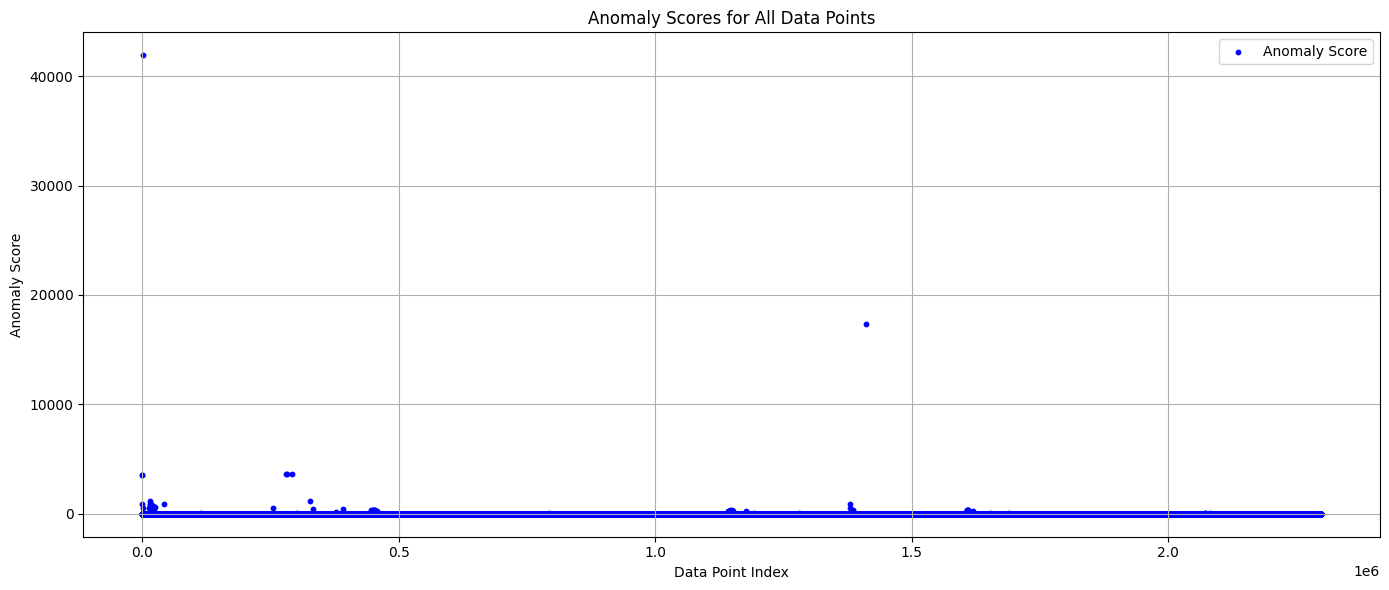

Autoencoder
Number of flows in Autoencoder_Test: 2298395
Correct data: 
Real number of anomalies in Autoencoder_Test: 556556
Procentage of anomlys in dataset: 24.2150%
Predicted data: 
Number of DETECTED anomalies in Autoencoder_Test: 367744
Procentage of anomlys in dataset: 16.0000%

Number of correct predictions(TP): 293976
Number of wrong predyctions(FP): 73768
Accuracy of predictions: 85.3660%
Sensitivity of predictions: 52.8206%
Precision of predictions: 79.9404%
F - mesure - harmonic-mean of precision and sensitivity: 63.6105%


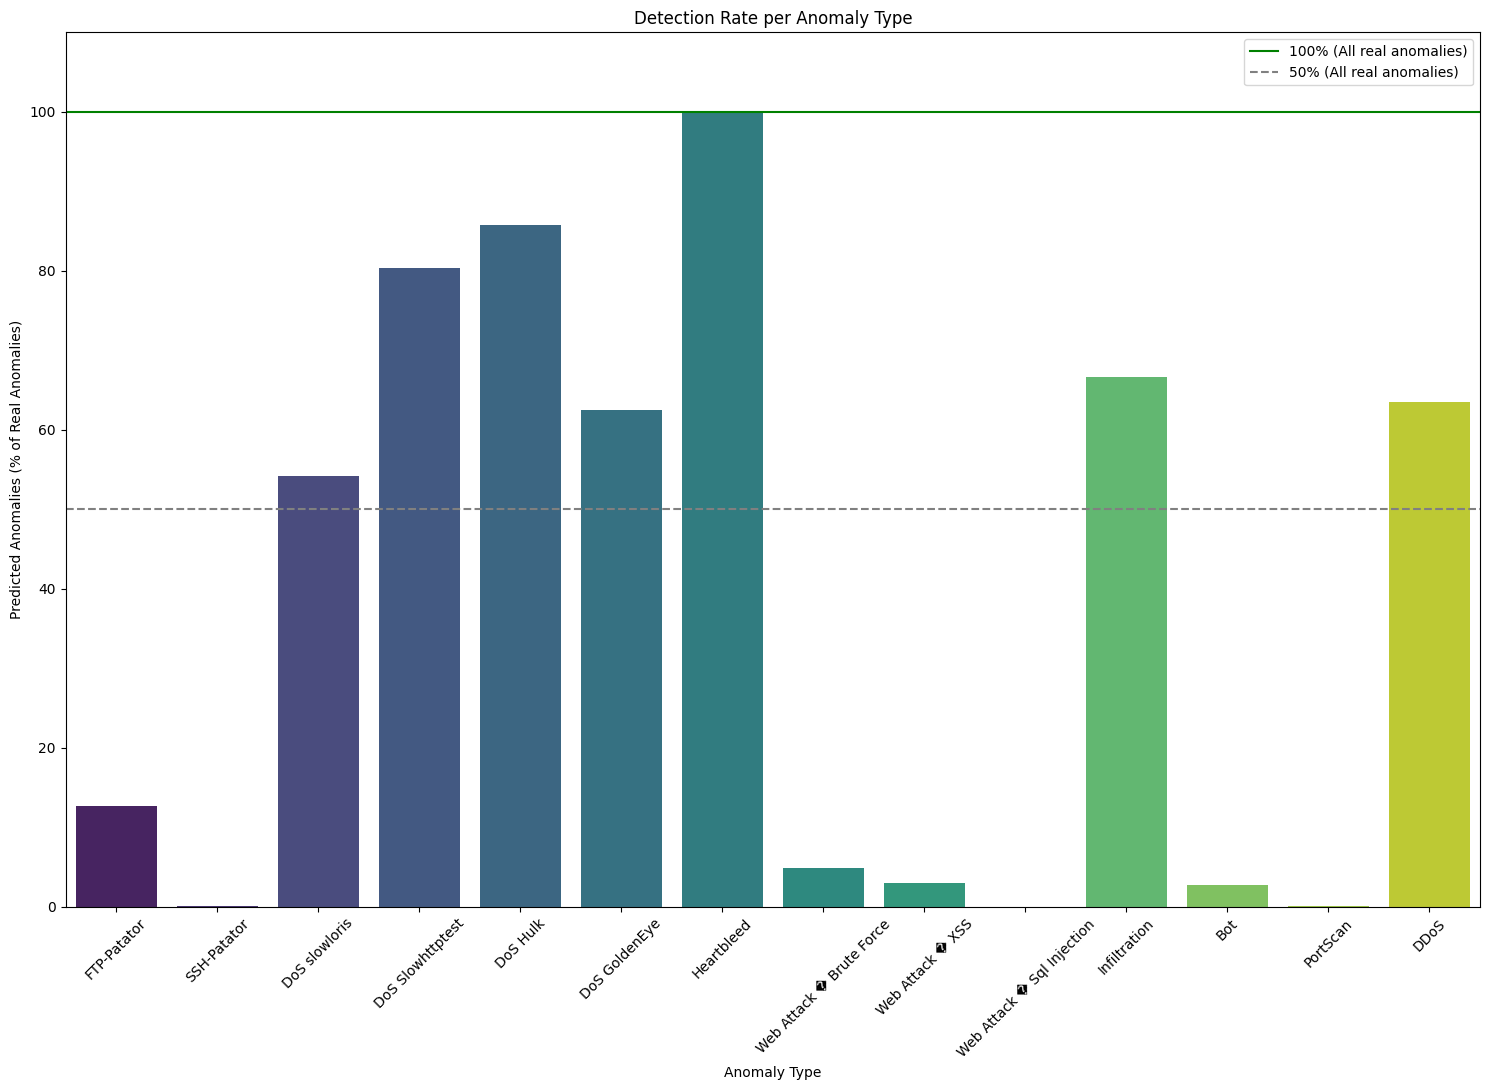

Detection rate by attack type:
Name: FTP-Patator, Detected: 12.6024%
Name: SSH-Patator, Detected: 0.0339%
Name: DoS slowloris, Detected: 54.1408%
Name: DoS Slowhttptest, Detected: 80.3055%
Name: DoS Hulk, Detected: 85.7612%
Name: DoS GoldenEye, Detected: 62.4794%
Name: Heartbleed, Detected: 100.0%
Name: Web Attack � Brute Force, Detected: 4.8441%
Name: Web Attack � XSS, Detected: 2.9141%
Name: Web Attack � Sql Injection, Detected: 0.0%
Name: Infiltration, Detected: 66.6667%
Name: Bot, Detected: 2.6585%
Name: PortScan, Detected: 0.0699%
Name: DDoS, Detected: 63.536%


In [36]:
X_test_tensor = torch.tensor(df_test_1.values, dtype=torch.float32)

# Step 3: Get reconstructed output
with torch.no_grad():
    reconstructed = model_A_1(X_test_tensor)

# Step 4: Compute reconstruction error (MSE per sample)
reconstruction_error = F.mse_loss(reconstructed, X_test_tensor, reduction='none')
reconstruction_error = reconstruction_error.mean(dim=1).numpy() 

threshold = 100 - round((reconstruction_error.sum() / len(reconstruction_error)) * 100 )

print(threshold)

threshold = np.percentile(reconstruction_error,threshold)  # e.g., top 5% are anomalous
predictions = (reconstruction_error > threshold).astype(int)

df_AF = pd.DataFrame()
df_AF["anomaly_score"] = reconstruction_error
df_AF["prediction"] = np.where(df_AF["anomaly_score"] > threshold, -1, 1)
df_AF["Label"] = df_test_1_labels.values  # assuming they match by index


df = funs.test_model(name="Autoencoder_Test", level=["start","Autoencoder"],ready = df_AF, flag = True)

<div style="text-align: center;color:#66ff7d; font-size: 50px; font-family: 'OCR A Extended', 'Lucida Console', 'Monaco', monospace; margin-top: 20px; line-height: 1.6;">
    debug

</div>

In [42]:
print(len(df_test_1))
df

2298395


,anomaly_score,prediction,Label
0,0.001121,1,BENIGN
1,0.001812,1,BENIGN
2,0.007637,1,BENIGN
3,0.001255,1,BENIGN
4,0.001868,1,BENIGN
...,...,...,...
2298390,0.000133,1,BENIGN
2298391,0.000133,1,BENIGN
2298392,0.000133,1,BENIGN
2298393,0.000084,1,BENIGN
